<a href="https://colab.research.google.com/github/Branth1/Project2/blob/master/Project2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Files

In [196]:
import datetime
from pandas import DataFrame
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import requests
import re
import time
import random
!pip install thredds_crawler
!pip install xarray
!pip install netcdf4
from thredds_crawler.crawl import Crawl
import numpy as np
import scipy.stats as ss

Adjust Timestamp

In [0]:
aa = datetime(1900, 1, 1)
bb = datetime(1970, 1, 1)
cc = timedelta(hours=8)
tdelta = bb-aa-cc

M2M With OOI Database

In [0]:
API_USERNAME = 'OOIAPI-0P4ULSXBWU9HJV'
API_TOKEN = 'TEMP-TOKEN-5IX2DTX932MR87'

## Oregon Shelf Surface Mooring

In [0]:
# Instrument Information
site = 'CE02SHSM'
node = 'SBD11'
instrument = '06-METBKA000'
method = 'telemetered'
stream = 'metbk_hourly'

api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL
data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

In [0]:
params = {
  'beginDT':'2019-01-01T00:00:00.000Z',
  'endDT':'2020-01-01T00:00:00.000Z',
  'format':'application/csv',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [0]:
r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
data = r.json()
#data
print(data['allURLs'][0])


https://opendap.oceanobservatories.org/thredds/catalog/ooi/branth@uw.edu/20200221T172131316Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly/catalog.html


Wait for download to complete

In [0]:
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1000): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(.5)

request completed


Retrieve only CSV Datafiles

In [198]:
#Added this url section to avoid resubmitting a request when colab times out
url='https://opendap.oceanobservatories.org/thredds/catalog/ooi/branth@uw.edu/20200221T172131316Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly/catalog.html'
#url = data['allURLs'][0]
c = Crawl(url, select=['.*\.csv$'], debug=False)
urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
print(urls)

['https://opendap.oceanobservatories.org/thredds/fileServer/ooi/branth@uw.edu/20200221T172131316Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly/deployment0010_CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly_20191231T002926-20200106T002926.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/branth@uw.edu/20200221T172131316Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly/deployment0010_CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly_20191229T002932-20200106T002932.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/branth@uw.edu/20200221T172131316Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly/deployment0010_CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly_20191227T002912-20200106T002912.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/branth@uw.edu/20200221T172131316Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly/deployment0010_CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_hourly_20191225T0029

Compile all files Into One Dataset

In [0]:
Data_c = []
#Go through all urls files pull csv files
for i, csv_file in enumerate(urls):
  #read csv files
  data_batch = pd.read_csv(urls[i])
  #build Data_c
  Data_c.append(data_batch)
  #combine all files
Data_c = pd.concat(Data_c)
#sort and overide index to eliminate dublicates
Data_c = Data_c.sort_values(by='time',ascending=True).reset_index(drop=True)

In [200]:
#Find Column Titles
Data_c

,obs,deployment,lat,lon,met_buoyfls,met_buoyfls_qc_executed,met_buoyfls_qc_results,met_buoyflx,met_buoyflx_qc_executed,met_buoyflx_qc_results,met_frshflx,met_frshflx_qc_executed,met_frshflx_qc_results,met_heatflx,met_heatflx_qc_executed,met_heatflx_qc_results,met_latnflx,met_latnflx_qc_executed,met_latnflx_qc_results,met_mommflx,met_mommflx_qc_executed,met_mommflx_qc_results,met_netlirr,met_netlirr_qc_executed,met_netlirr_qc_results,met_netsirr_hourly,met_rainflx,met_rainflx_qc_executed,met_rainflx_qc_results,met_rainrte,met_rainrte_qc_executed,met_rainrte_qc_results,met_sensflx,met_sensflx_qc_executed,met_sensflx_qc_results,met_sphum2m,met_sphum2m_qc_executed,met_sphum2m_qc_results,met_stablty,met_tempa2m,met_tempa2m_qc_executed,met_tempa2m_qc_results,met_tempskn,met_tempskn_qc_executed,met_tempskn_qc_results,met_timeflx,met_wind10m,met_wind10m_qc_executed,met_wind10m_qc_results,metbk_a_dcl_instrument-air_temperature,metbk_a_dcl_instrument-barometric_pressure,metbk_a_dcl_instrument-longwave_irradiance,metbk_a_dcl_instrument-met_relwind_speed,metbk_a_dcl_instrument-precipitation,metbk_a_dcl_instrument-relative_humidity,metbk_a_dcl_instrument-sea_surface_temperature,metbk_a_dcl_instrument-shortwave_irradiance,time,velpt_ab_dcl_instrument-eastward_velocity,velpt_ab_dcl_instrument-northward_velocity
0,"('0',)",8,44.63950,-124.3015,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,35.954926,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755291e+09,NaN,29,28,8.424006,1029.322652,258.168333,5.185671,19.538634,56.752800,11.046180,21.004979,3.755291e+09,-0.215449,-0.112573
1,"('1',)",8,44.63950,-124.3015,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,2.079000,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755295e+09,NaN,29,28,8.679031,1028.725600,270.607314,4.269917,19.490731,62.129941,10.965196,1.900000,3.755295e+09,-0.077340,-0.240989
2,"('2',)",8,44.63950,-124.3015,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,1.666350,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755299e+09,NaN,29,28,8.269802,1028.979552,262.032222,5.894189,19.467170,68.860470,10.962395,1.800000,3.755299e+09,-0.168923,-0.161881
3,"('3',)",8,44.63950,-124.3015,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,1.566458,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755302e+09,NaN,29,28,7.294690,1028.675813,253.899994,3.619239,19.440141,69.968919,10.928099,1.602815,3.755302e+09,-0.230579,-0.087425
4,"('4',)",8,44.63950,-124.3015,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,1.428525,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755306e+09,NaN,29,28,7.256364,1028.347071,251.699997,3.687133,19.437955,64.624743,10.913659,1.400000,3.755306e+09,-0.128043,-0.174120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9082,"('49',)",10,44.63958,-124.3030,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,28.066501,NaN,16,16,0.169427,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.787259e+09,NaN,29,28,9.232000,1032.040039,324.899994,6.102496,32.660000,81.212997,10.528000,29.700001,3.787259e+09,0.016276,-0.125412
9083,"('49',)",10,44.63958,-124.3030,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,28.066501,NaN,16,16,0.000000,29,29,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.787259e+09,NaN,29,28,9.232000,1032.040039,324.899994,6.102496,32.660000,81.212997,10.528000,29.700001,3.787259e+09,0.016276,-0.125412
9084,"('24',)",10,44.63958,-124.3030,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,28.066501,NaN,16,16,0.221652,29,29,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.787259e+09,NaN,29,28,9.2

Define Variables and Plot

In [0]:
rain=Data_c.met_rainrte
Data_c.time = pd.to_datetime(Data_c.time,unit='s')
time=Data_c.time-tdelta
x=time
wind=Data_c['metbk_a_dcl_instrument-met_relwind_speed']

Blue = No wind or Rain
Green = Wind but No Rain
Red = Rain and No Wind
Yellow = Rain and Wind


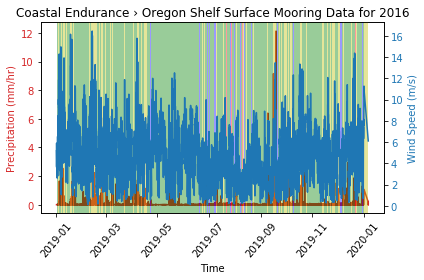

In [202]:
fig, ax1 = plt.subplots()
plt.title('Coastal Endurance › Oregon Shelf Surface Mooring Data for 2016')
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Precipitation (mm/hr)', color=color)
ax1.plot(x, rain, color=color)
ax1.tick_params(axis='y', labelcolor=color)
degrees = 50
plt.xticks(rotation=degrees)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Wind Speed (m/s)', color=color)  # we already handled the x-label with ax1
ax2.plot(x, wind, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

#Add Colored Verticle Bars for Different Scenarios
for i in range(0,len(x)-1):
        if wind[i]/np.mean(wind) < .30 and rain[i]/np.mean(rain) < .30:
          #no wind or rain
            plt.axvspan(x[i], x[i+1], facecolor='b', alpha=.4, zorder=-100)
        elif wind[i]/np.mean(wind) >= .30 and rain[i]/np.mean(rain) < .30:
          #wind and no rain
            plt.axvspan(x[i], x[i+1], facecolor='g', alpha=.4, zorder=-100)
        elif wind[i]/np.mean(wind) < .30 and rain[i]/np.mean(rain) >= .30:
          #rain and no wind
            plt.axvspan(x[i], x[i+1], facecolor='r', alpha=.4, zorder=-100)
        elif wind[i]/np.mean(wind) >= .30 and rain[i]/np.mean(rain) >= .30:
           #rain and wind
           plt.axvspan(x[i], x[i+1], facecolor='y', alpha=.4, zorder=-100)
        
#Print Legend
print('Blue = No wind or Rain')
print('Green = Wind but No Rain')
print('Red = Rain and No Wind')
print('Yellow = Rain and Wind')

## Oregon Offshore Surface Mooring

In [0]:
# Instrument Information
site = 'CE04OSSM'
node = 'SBD11'
instrument = '06-METBKA000'
method = 'telemetered'
stream = 'metbk_hourly'

api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the request URL
data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

In [0]:
params = {
  'beginDT':'2019-01-01T00:00:00.000Z',
  'endDT':'2020-01-01T00:00:00.000Z',
  'format':'application/csv',
  'include_provenance':'true',
  'include_annotations':'true'
}

In [0]:
r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
data = r.json()
#data
print(data['allURLs'][0])


https://opendap.oceanobservatories.org/thredds/catalog/ooi/branth@uw.edu/20200221T023236477Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly/catalog.html


Wait for download to complete

In [0]:
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1000): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(.5)

Retrieve only CSV Datafiles

In [0]:
url2 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/branth@uw.edu/20200221T023236477Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly/catalog.html'
#url2 = data['allURLs'][0]
c = Crawl(url2, select=['.*\.csv$'], debug=False)
urls2 = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
print(urls2)

['https://opendap.oceanobservatories.org/thredds/fileServer/ooi/branth@uw.edu/20200221T023236477Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly/deployment0009_CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly_20191231T002947-20200106T002947.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/branth@uw.edu/20200221T023236477Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly/deployment0009_CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly_20191229T002930-20200106T002930.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/branth@uw.edu/20200221T023236477Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly/deployment0009_CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly_20191227T002937-20200106T002937.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/branth@uw.edu/20200221T023236477Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly/deployment0009_CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_hourly_20191225T0029

Compile all files Into One Dataset

In [0]:
Data_d = []
#Go through all urls2 files pull csv files
for i, csv_file in enumerate(urls2):
  #read csv files
  data_batch2 = pd.read_csv(urls2[i])
  #build Data_c
  Data_d.append(data_batch2)
  #combine all files
Data_d = pd.concat(Data_d)
#sort and overide index to eliminate dublicates
Data_d = Data_d.sort_values(by='time',ascending=True).reset_index(drop=True)

In [0]:
#Find Column Titles
Data_d

,obs,deployment,lat,lon,met_buoyfls,met_buoyfls_qc_executed,met_buoyfls_qc_results,met_buoyflx,met_buoyflx_qc_executed,met_buoyflx_qc_results,met_frshflx,met_frshflx_qc_executed,met_frshflx_qc_results,met_heatflx,met_heatflx_qc_executed,met_heatflx_qc_results,met_latnflx,met_latnflx_qc_executed,met_latnflx_qc_results,met_mommflx,met_mommflx_qc_executed,met_mommflx_qc_results,met_netlirr,met_netlirr_qc_executed,met_netlirr_qc_results,met_netsirr_hourly,met_rainflx,met_rainflx_qc_executed,met_rainflx_qc_results,met_rainrte,met_rainrte_qc_executed,met_rainrte_qc_results,met_sensflx,met_sensflx_qc_executed,met_sensflx_qc_results,met_sphum2m,met_sphum2m_qc_executed,met_sphum2m_qc_results,met_stablty,met_tempa2m,met_tempa2m_qc_executed,met_tempa2m_qc_results,met_tempskn,met_tempskn_qc_executed,met_tempskn_qc_results,met_timeflx,met_wind10m,met_wind10m_qc_executed,met_wind10m_qc_results,metbk_a_dcl_instrument-air_temperature,metbk_a_dcl_instrument-barometric_pressure,metbk_a_dcl_instrument-longwave_irradiance,metbk_a_dcl_instrument-met_relwind_speed,metbk_a_dcl_instrument-precipitation,metbk_a_dcl_instrument-relative_humidity,metbk_a_dcl_instrument-sea_surface_temperature,metbk_a_dcl_instrument-shortwave_irradiance,time,velpt_ab_dcl_instrument-eastward_velocity,velpt_ab_dcl_instrument-northward_velocity
0,"('0',)",7,44.380,-124.950,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,29.106000,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755290e+09,NaN,29,28,8.356106,1029.179746,270.594242,4.132087,44.193002,67.732889,11.664022,76.170770,3.755290e+09,-0.090526,-0.311317
1,"('1',)",7,44.380,-124.950,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,10.962000,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755294e+09,NaN,29,28,8.450432,1029.010010,266.197277,5.464732,44.139637,62.585592,11.659555,10.114495,3.755294e+09,-0.072728,-0.274079
2,"('2',)",7,44.380,-124.950,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,3.295687,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755301e+09,NaN,29,28,9.018481,1029.010010,267.804316,5.797183,44.097714,59.659408,11.665843,4.105616,3.755301e+09,-0.045348,-0.280088
3,"('3',)",7,44.380,-124.950,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,3.496500,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755305e+09,NaN,29,28,9.058351,1028.865991,267.952936,6.376345,44.095206,60.115871,11.685191,5.678196,3.755305e+09,-0.041753,-0.263359
4,"('4',)",7,44.380,-124.950,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,4.240688,NaN,16,16,0.008125,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.755312e+09,NaN,29,28,8.738154,1028.287015,266.557740,3.699574,44.116133,56.272108,11.653799,13.630811,3.755312e+09,-0.045113,-0.209282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,"('49',)",9,44.378,-124.946,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,50.179499,NaN,16,16,0.000000,29,29,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.787259e+09,NaN,29,28,9.752000,1032.530029,318.799988,4.263711,33.430000,76.539001,10.555000,53.099998,3.787259e+09,-0.219875,0.145640
8617,"('48',)",9,44.378,-124.946,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,50.179499,NaN,16,16,0.000000,29,13,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.787259e+09,NaN,29,28,9.752000,1032.530029,318.799988,4.263711,33.430000,76.539001,10.555000,53.099998,3.787259e+09,-0.219875,0.145640
8618,"('49',)",9,44.378,-124.946,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,16,16,NaN,29,28,50.179499,NaN,16,16,0.000000,29,29,NaN,16,16,NaN,29,28,NaN,NaN,29,28,NaN,29,28,3.787259e+09,NaN,29,28,9.752000,1032.530029,318.79

Define Variables and Plot

In [0]:
rain2=Data_d.met_rainrte
Data_d.time = pd.to_datetime(Data_d.time,unit='s')
time=Data_d.time-tdelta
x2=time
wind2=Data_d['metbk_a_dcl_instrument-met_relwind_speed']

Blue = No wind or Rain
Green = Wind but No Rain
Red = Rain and No Wind
Yellow = Rain and Wind


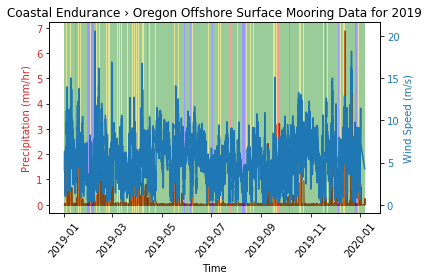

In [0]:
fig2, ax1 = plt.subplots()
plt.title('Coastal Endurance › Oregon Offshore Surface Mooring Data for 2019')
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Precipitation (mm/hr)', color=color)
ax1.plot(x2, rain2, color=color)
ax1.tick_params(axis='y', labelcolor=color)
degrees = 50
plt.xticks(rotation=degrees)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Wind Speed (m/s)', color=color)  # we already handled the x-label with ax1
ax2.plot(x2, wind2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig2.tight_layout()  # otherwise the right y-label is slightly clipped

#Add Colored Verticle Bars for Different Scenarios
for i in range(0,len(x2)-1):
        if wind2[i]/np.mean(wind2) < .30 and rain2[i]/np.mean(rain2) < .30:
          #no wind or rain
            plt.axvspan(x2[i], x2[i+1], facecolor='b', alpha=.4, zorder=-100)
        elif wind2[i]/np.mean(wind2) >= .30 and rain2[i]/np.mean(rain2) < .30:
          #wind and no rain
            plt.axvspan(x2[i], x2[i+1], facecolor='g', alpha=.4, zorder=-100)
        elif wind2[i]/np.mean(wind2) < .30 and rain2[i]/np.mean(rain2) >= .30:
          #rain and no wind
            plt.axvspan(x2[i], x2[i+1], facecolor='r', alpha=.4, zorder=-100)
        elif wind2[i]/np.mean(wind2) >= .30 and rain2[i]/np.mean(rain2) >= .30:
           #rain and wind
           plt.axvspan(x2[i], x2[i+1], facecolor='y', alpha=.4, zorder=-100)
        
          
#Print Legend
print('Blue = No wind or Rain')
print('Green = Wind but No Rain')
print('Red = Rain and No Wind')
print('Yellow = Rain and Wind')

Unused Code from previous work

In [0]:
#ds = xr.open_mfdataset(selected_datasets, combine='_old_auto')
#ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
#ds = ds.chunk({'time': 100}) # Used for optimization
#ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
#ds
# url = data['allURLs'][0]
# tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
# datasets = requests.get(url).text
# urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
# x = re.findall(r'(ooi/.*?.csv)', datasets)
# for i in x:
#     if i.endswith('.csv') == False:
#         x.remove(i)
# for i in x:
#     try:
#         float(i[-4])
#     except:
#         x.remove(i)
# #datasets = [os.path.join(tds_url, i) for i in x]
# datasets

# #Remove VELPT file
# selected_datasets = []
# for d in datasets:
#     if 'VELPT' in d:
#         pass
#     else:
#         selected_datasets.append(d)
selected_datasets

#Change file names to avoid NetCDF error
#for index, value in enumerate(selected_datasets):
 #   selected_datasets[index] = value + '#fillmismatch'
#selected_datasets

In [0]:
# ym = np.ma.masked_invalid(rain)
# y_orig = rain.copy()
# fig, ax = plt.subplots()
# #ax.plot(x, ym, 'bo', label='retained', zorder=-100)
# ax.plot(x[ym.mask], y_orig[ym.mask], 'ro', label='deleted')
# ax.set_ylim([-10, 10])
# ax.legend(loc='upper right', fontsize='small', ncol=2)


1    8.702694
1    4.605664
1    5.577714
1    0.458337
1    5.530411
       ...   
1    3.066162
1    5.632856
1    4.844548
1    7.887227
1    8.269091
Name: metbk_a_dcl_instrument_recovered-met_relwind_speed, Length: 187, dtype: float64

# Coorelation Wind

max correlation is at lag -2971


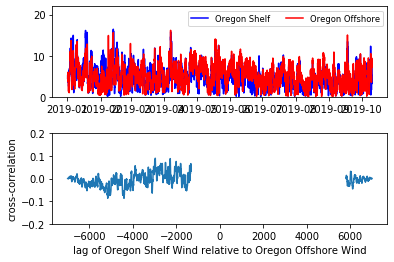

In [203]:
npts = 7000
x3 = x[0:7000]
#y1 = wind[0:7000]
#y2 = wind2[0:7000]
y1 = np.interp(x3, x, wind)
y2f = np.interp(x3, x2, wind2)
y2 = np.ma.masked_invalid(y2f)

lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - np.mean(y1), y2 - np.mean(y2), mode='full')
ccor = ccov / (npts * np.std(y1) * np.std(y2))

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x3, y1, 'b', label='Oregon Shelf')
ax.plot(x3, y2, 'r', label='Oregon Offshore')
ax.set_ylim(-0, 22)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylim(-.2, .2)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of Oregon Shelf Wind relative to Oregon Offshore Wind')

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)


Calculate Max Correlation Value

In [0]:
np.interp(maxlag,lags,ccor)

0.08574892984453954

# Coorelation Rain

max correlation is at lag 1


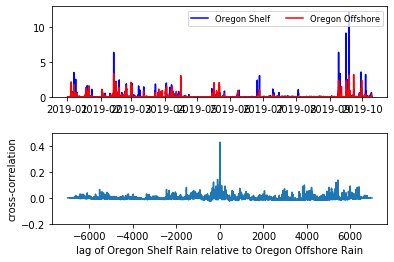

In [0]:
npts = 7000
x4 = x[0:7000]
y1 = np.interp(x3, x, rain)
y2f = np.interp(x3, x2, rain2)
y2 = np.ma.masked_invalid(y2f)

lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - np.mean(y1), y2 - np.mean(y2), mode='full')
ccor = ccov / (npts * np.std(y1) * np.std(y2))

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x4, y1, 'b', label='Oregon Shelf')
ax.plot(x4, y2, 'r', label='Oregon Offshore')
ax.set_ylim(-0, 13)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylim(-.2, .5)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of Oregon Shelf Rain relative to Oregon Offshore Rain')

maxlag = lags[np.argmax(ccor)]
maxcor = np.interp(maxlag,lags,ccor)
print("max correlation is at lag %d" % maxlag)

Calculate Max Coorelation Value

In [0]:
maxcor
#np.interp(maxlag,lags,ccor)

0.4306206507691159

# Monthly Average Wind Speed

In [0]:
    #Oregon Shelf Variables
# rain=Data_c.met_rainrte
# Data_c.time = pd.to_datetime(Data_c.time,unit='s')
# time=Data_c.time-tdelta
# x=time
# wind=Data_c['metbk_a_dcl_instrument_recovered-met_relwind_speed']

    #Oregon Offshore Variables
# rain2=Data_d.met_rainrte
# Data_d.time = pd.to_datetime(Data_d.time,unit='s')
# time=Data_d.time-tdelta
# x2=time
# wind2=Data_d['metbk_a_dcl_instrument-met_relwind_speed']

In [0]:
#Create Month List
Months = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
OSW = []
OOW = []

Calculate Averages For Oregon Shelf

In [0]:
Jan_end = x[x<='2019-02-01'].index.tolist()
#Jan_end
Jan_end = np.max(Jan_end)
Jan_wind=wind[0:Jan_end]
Jan_wind_av=sum(Jan_wind)/len(Jan_wind)
OSW.append(Jan_wind_av)

Feb_end = x[x<='2019-03-01'].index.tolist()
Feb_end = np.max(Feb_end)
Feb_wind=wind[Jan_end+1:Feb_end]
Feb_wind_av=sum(Feb_wind)/len(Feb_wind)
OSW.append(Feb_wind_av)

Mar_end = x[x<='2019-04-01'].index.tolist()
Mar_end = np.max(Mar_end)
Mar_wind=wind[Feb_end+1:Mar_end]
Mar_wind_av=sum(Mar_wind)/len(Mar_wind)
OSW.append(Mar_wind_av)

Apr_end = x[x<='2019-05-01'].index.tolist()
Apr_end = np.max(Apr_end)
Apr_wind=wind[Mar_end+1:Apr_end]
Apr_wind_av=sum(Apr_wind)/len(Apr_wind)
OSW.append(Apr_wind_av)

May_end = x[x<='2019-06-01'].index.tolist()
May_end = np.max(May_end)
May_wind=wind[Apr_end+1:May_end]
May_wind_av=sum(May_wind)/len(May_wind)
OSW.append(May_wind_av)

Jun_end = x[x<='2019-07-01'].index.tolist()
Jun_end = np.max(Jun_end)
Jun_wind=wind[May_end+1:Jun_end]
Jun_wind_av=sum(Jun_wind)/len(Jun_wind)
OSW.append(Jun_wind_av)

Jul_end = x[x<='2019-08-01'].index.tolist()
Jul_end = np.max(Jul_end)
Jul_wind=wind[Jun_end+1:Jul_end]
Jul_wind_av=sum(Jul_wind)/len(Jul_wind)
OSW.append(Jul_wind_av)

Aug_end = x[x<='2019-09-01'].index.tolist()
Aug_end = np.max(Aug_end)
Aug_wind=wind[Jul_end+1:Aug_end]
Aug_wind_av=sum(Aug_wind)/len(Aug_wind)
OSW.append(Aug_wind_av)

Sep_end = x[x<='2019-10-01'].index.tolist()
Sep_end = np.max(Sep_end)
Sep_wind=wind[Aug_end+1:Sep_end]
Sep_wind_av=sum(Sep_wind)/len(Sep_wind)
OSW.append(Sep_wind_av)

Oct_end = x[x<='2019-11-01'].index.tolist()
Oct_end = np.max(Oct_end)
Oct_wind=wind[Sep_end+1:Oct_end]
Oct_wind_av=sum(Oct_wind)/len(Oct_wind)
OSW.append(Oct_wind_av)

Nov_end = x[x<='2019-12-01'].index.tolist()
Nov_end = np.max(Nov_end)
Nov_wind=wind[Oct_end+1:Nov_end]
Nov_wind_av=sum(Nov_wind)/len(Nov_wind)
OSW.append(Nov_wind_av)

Dec_end = x[x<='2020-01-01'].index.tolist()
Dec_end = np.max(Dec_end)
Dec_wind=wind[Nov_end+1:Dec_end]
Dec_wind_av=sum(Dec_wind)/len(Dec_wind)
OSW.append(Dec_wind_av)

Calculate Averages for Oregon Offshore

In [0]:
Jan_end = x2[x2<='2019-02-01'].index.tolist()
#Jan_end
Jan_end = np.max(Jan_end)
Jan_wind=wind[0:Jan_end]
Jan_wind_av=sum(Jan_wind)/len(Jan_wind)
OOW.append(Jan_wind_av)

Feb_end = x2[x2<='2019-03-01'].index.tolist()
Feb_end = np.max(Feb_end)
Feb_wind=wind[Jan_end+1:Feb_end]
Feb_wind_av=sum(Feb_wind)/len(Feb_wind)
OOW.append(Feb_wind_av)

Mar_end = x2[x2<='2019-04-01'].index.tolist()
Mar_end = np.max(Mar_end)
Mar_wind=wind[Feb_end+1:Mar_end]
Mar_wind_av=sum(Mar_wind)/len(Mar_wind)
OOW.append(Mar_wind_av)

Apr_end = x2[x2<='2019-05-01'].index.tolist()
Apr_end = np.max(Apr_end)
Apr_wind=wind[Mar_end+1:Apr_end]
Apr_wind_av=sum(Apr_wind)/len(Apr_wind)
OOW.append(Apr_wind_av)

May_end = x2[x2<='2019-06-01'].index.tolist()
May_end = np.max(May_end)
May_wind=wind[Apr_end+1:May_end]
May_wind_av=sum(May_wind)/len(May_wind)
OOW.append(May_wind_av)

Jun_end = x2[x2<='2019-07-01'].index.tolist()
Jun_end = np.max(Jun_end)
Jun_wind=wind[May_end+1:Jun_end]
Jun_wind_av=sum(Jun_wind)/len(Jun_wind)
OOW.append(Jun_wind_av)

Jul_end = x2[x2<='2019-08-01'].index.tolist()
Jul_end = np.max(Jul_end)
Jul_wind=wind[Jun_end+1:Jul_end]
Jul_wind_av=sum(Jul_wind)/len(Jul_wind)
OOW.append(Jul_wind_av)

Aug_end = x2[x2<='2019-09-01'].index.tolist()
Aug_end = np.max(Aug_end)
Aug_wind=wind[Jul_end+1:Aug_end]
Aug_wind_av=sum(Aug_wind)/len(Aug_wind)
OOW.append(Aug_wind_av)

Sep_end = x2[x2<='2019-10-01'].index.tolist()
Sep_end = np.max(Sep_end)
Sep_wind=wind[Aug_end+1:Sep_end]
Sep_wind_av=sum(Sep_wind)/len(Sep_wind)
OOW.append(Sep_wind_av)

Oct_end = x2[x2<='2019-11-01'].index.tolist()
Oct_end = np.max(Oct_end)
Oct_wind=wind[Sep_end+1:Oct_end]
Oct_wind_av=sum(Oct_wind)/len(Oct_wind)
OOW.append(Oct_wind_av)

Nov_end = x2[x2<='2019-12-01'].index.tolist()
Nov_end = np.max(Nov_end)
Nov_wind=wind[Oct_end+1:Nov_end]
Nov_wind_av=sum(Nov_wind)/len(Nov_wind)
OOW.append(Nov_wind_av)

Dec_end = x2[x2<='2020-01-01'].index.tolist()
Dec_end = np.max(Dec_end)
Dec_wind=wind[Nov_end+1:Dec_end]
Dec_wind_av=sum(Dec_wind)/len(Dec_wind)
OOW.append(Dec_wind_av)

Plot Wind Averages for Both Sites

Text(0.5, 1.0, 'Average Wind Throughout 2019')

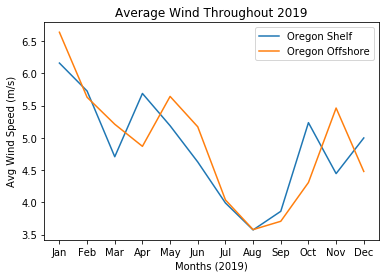

In [227]:
plt.plot(Months,OSW)
plt.plot(Months,OOW)
plt.ylabel('Avg Wind Speed (m/s)')
plt.xlabel('Months (2019)')
plt.legend(("Oregon Shelf","Oregon Offshore"))
plt.title('Average Wind Throughout 2019')

# Monthly Average Rain Rate

In [0]:
    #Oregon Shelf Variables
# rain=Data_c.met_rainrte
# Data_c.time = pd.to_datetime(Data_c.time,unit='s')
# time=Data_c.time-tdelta
# x=time
# wind=Data_c['metbk_a_dcl_instrument_recovered-met_relwind_speed']

    #Oregon Offshore Variables
# rain2=Data_d.met_rainrte
# Data_d.time = pd.to_datetime(Data_d.time,unit='s')
# time=Data_d.time-tdelta
# x2=time
# wind2=Data_d['metbk_a_dcl_instrument-met_relwind_speed']

In [0]:
#Create Month List
Months = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
OSR = []
OOR = []

Calculate Averages For Oregon Shelf

In [0]:
Jan_end = x[x<='2019-02-01'].index.tolist()
#Jan_end
Jan_end = np.max(Jan_end)
Jan_wind=rain[0:Jan_end]
Jan_wind_av=sum(Jan_wind)/len(Jan_wind)
OSR.append(Jan_wind_av)

Feb_end = x[x<='2019-03-01'].index.tolist()
Feb_end = np.max(Feb_end)
Feb_wind=rain[Jan_end+1:Feb_end]
Feb_wind_av=sum(Feb_wind)/len(Feb_wind)
OSR.append(Feb_wind_av)

Mar_end = x[x<='2019-04-01'].index.tolist()
Mar_end = np.max(Mar_end)
Mar_wind=rain[Feb_end+1:Mar_end]
Mar_wind_av=sum(Mar_wind)/len(Mar_wind)
OSR.append(Mar_wind_av)

Apr_end = x[x<='2019-05-01'].index.tolist()
Apr_end = np.max(Apr_end)
Apr_wind=rain[Mar_end+1:Apr_end]
Apr_wind_av=sum(Apr_wind)/len(Apr_wind)
OSR.append(Apr_wind_av)

May_end = x[x<='2019-06-01'].index.tolist()
May_end = np.max(May_end)
May_wind=rain[Apr_end+1:May_end]
May_wind_av=sum(May_wind)/len(May_wind)
OSR.append(May_wind_av)

Jun_end = x[x<='2019-07-01'].index.tolist()
Jun_end = np.max(Jun_end)
Jun_wind=rain[May_end+1:Jun_end]
Jun_wind_av=sum(Jun_wind)/len(Jun_wind)
OSR.append(Jun_wind_av)

Jul_end = x[x<='2019-08-01'].index.tolist()
Jul_end = np.max(Jul_end)
Jul_wind=rain[Jun_end+1:Jul_end]
Jul_wind_av=sum(Jul_wind)/len(Jul_wind)
OSR.append(Jul_wind_av)

Aug_end = x[x<='2019-09-01'].index.tolist()
Aug_end = np.max(Aug_end)
Aug_wind=rain[Jul_end+1:Aug_end]
Aug_wind_av=sum(Aug_wind)/len(Aug_wind)
OSR.append(Aug_wind_av)

Sep_end = x[x<='2019-10-01'].index.tolist()
Sep_end = np.max(Sep_end)
Sep_wind=rain[Aug_end+1:Sep_end]
Sep_wind_av=sum(Sep_wind)/len(Sep_wind)
OSR.append(Sep_wind_av)

Oct_end = x[x<='2019-11-01'].index.tolist()
Oct_end = np.max(Oct_end)
Oct_wind=rain[Sep_end+1:Oct_end]
Oct_wind_av=sum(Oct_wind)/len(Oct_wind)
OSR.append(Oct_wind_av)

Nov_end = x[x<='2019-12-01'].index.tolist()
Nov_end = np.max(Nov_end)
Nov_wind=rain[Oct_end+1:Nov_end]
Nov_wind_av=sum(Nov_wind)/len(Nov_wind)
OSR.append(Nov_wind_av)

Dec_end = x[x<='2020-01-01'].index.tolist()
Dec_end = np.max(Dec_end)
Dec_wind=rain[Nov_end+1:Dec_end]
Dec_wind_av=sum(Dec_wind)/len(Dec_wind)
OSR.append(Dec_wind_av)

Calculate Averages for Oregon Offshore

In [0]:
Jan_end = x2[x2<='2019-02-01'].index.tolist()
#Jan_end
Jan_end = np.max(Jan_end)
Jan_wind=rain2[0:Jan_end]
Jan_wind_av=sum(Jan_wind)/len(Jan_wind)
OOR.append(Jan_wind_av)

Feb_end = x2[x2<='2019-03-01'].index.tolist()
Feb_end = np.max(Feb_end)
Feb_wind=rain2[Jan_end+1:Feb_end]
Feb_wind_av=sum(Feb_wind)/len(Feb_wind)
OOR.append(Feb_wind_av)

Mar_end = x2[x2<='2019-04-01'].index.tolist()
Mar_end = np.max(Mar_end)
Mar_wind=rain2[Feb_end+1:Mar_end]
Mar_wind_av=sum(Mar_wind)/len(Mar_wind)
OOR.append(Mar_wind_av)

Apr_end = x2[x2<='2019-05-01'].index.tolist()
Apr_end = np.max(Apr_end)
Apr_wind=rain2[Mar_end+1:Apr_end]
Apr_wind_av=sum(Apr_wind)/len(Apr_wind)
OOR.append(Apr_wind_av)

May_end = x2[x2<='2019-06-01'].index.tolist()
May_end = np.max(May_end)
May_wind=rain2[Apr_end+1:May_end]
May_wind_av=sum(May_wind)/len(May_wind)
OOR.append(May_wind_av)

Jun_end = x2[x2<='2019-07-01'].index.tolist()
Jun_end = np.max(Jun_end)
Jun_wind=rain2[May_end+1:Jun_end]
Jun_wind_av=sum(Jun_wind)/len(Jun_wind)
OOR.append(Jun_wind_av)

Jul_end = x2[x2<='2019-08-01'].index.tolist()
Jul_end = np.max(Jul_end)
Jul_wind=rain2[Jun_end+1:Jul_end]
Jul_wind_av=sum(Jul_wind)/len(Jul_wind)
OOR.append(Jul_wind_av)

Aug_end = x2[x2<='2019-09-01'].index.tolist()
Aug_end = np.max(Aug_end)
Aug_wind=rain2[Jul_end+1:Aug_end]
Aug_wind_av=sum(Aug_wind)/len(Aug_wind)
OOR.append(Aug_wind_av)

Sep_end = x2[x2<='2019-10-01'].index.tolist()
Sep_end = np.max(Sep_end)
Sep_wind=rain2[Aug_end+1:Sep_end]
Sep_wind_av=sum(Sep_wind)/len(Sep_wind)
OOR.append(Sep_wind_av)

Oct_end = x2[x2<='2019-11-01'].index.tolist()
Oct_end = np.max(Oct_end)
Oct_wind=rain2[Sep_end+1:Oct_end]
Oct_wind_av=sum(Oct_wind)/len(Oct_wind)
OOR.append(Oct_wind_av)

Nov_end = x2[x2<='2019-12-01'].index.tolist()
Nov_end = np.max(Nov_end)
Nov_wind=rain2[Oct_end+1:Nov_end]
Nov_wind_av=sum(Nov_wind)/len(Nov_wind)
OOR.append(Nov_wind_av)

Dec_end = x2[x2<='2020-01-01'].index.tolist()
Dec_end = np.max(Dec_end)
Dec_wind=rain2[Nov_end+1:Dec_end]
Dec_wind_av=sum(Dec_wind)/len(Dec_wind)
OOR.append(Dec_wind_av)

Plot Wind Averages for Both Sites

Text(0.5, 1.0, 'Average Rain Throughout 2019')

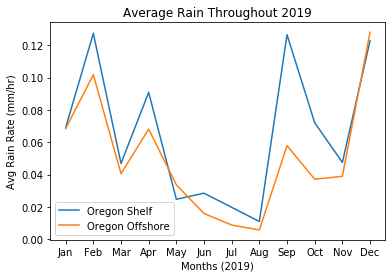

In [223]:
plt.plot(Months,OSR)
plt.plot(Months,OOR)
plt.ylabel('Avg Rain Rate (mm/hr)')
plt.xlabel('Months (2019)')
plt.legend(("Oregon Shelf","Oregon Offshore"))
plt.title('Average Rain Throughout 2019')

In [0]:
# Jan_start = datetime.datetime(2019, 1, 1, 0, 0)
# Feb_start = datetime.datetime(2019, 2, 1, 0, 0)
# #def filter_dates(date_list, Jan_start):

# Jan_dates = []

# for dates in x:
#     dates_jan = [date for date in dates if date >=Jan_start  and date for date in dates < Feb_start]
#     Jan_dates.append([dates_jan])
# return Jan_dates


AttributeError: ignored

In [0]:
# # List of Timestamps
# list_of_dates = [[Timestamp('2018-04-07 00:00:00'), Timestamp('2018-07-07 00:00:00'), Timestamp('2020-04-07 00:00:00')], [Timestamp('2018-04-07 00:00:00'), Timestamp('2018-10-07 00:00:00'), Timestamp('2018-12-07 00:00:00'), Timestamp('2021-04-07 00:00:00'), Timestamp('2022-04-07 00:00:00'), Timestamp('2023-04-07 00:00:00')]]

# # Target date that we use as filter
# target_date = datetime.datetime(2019, 1, 26, 0, 0)

# def filter_dates(date_list, target_date):
#   """Filter given timestamps according to target date.

#   Keep last date before target date and all future dates after target date."""

#   # Initialise return list
#   filtered_dates = []

#   # Iterate over list of lists
#   for dates in date_list:

#     # Use list comprehension to filter dates that are on either sides of the target date
#     dates_before_target_date = [date for date in dates if date < target_date]
#     dates_after_target_date = [date for date in dates if date > target_date]

#     # Keep last date before the target date and all future dates
#     filtered_dates.append([dates_before_target_date[-1]] + dates_after_target_date)

#   return filtered_dates

# filtered_dates = filter_dates(list_of_dates, target_date)
# print(filtered_dates)

In [0]:
# Jan_start = datetime.datetime(2019, 1, 1, 0, 0)
# Feb_start = datetime.datetime(2019, 2, 1, 0, 0)
# #def filter_dates(date_list, Jan_start):

# Jan_dates = []

# for dates in x:
#     dates_jan = [date for date in dates if date >=Jan_start  and date for date in dates < Feb_start]
#     Jan_dates.append([dates_jan])
# return Jan_dates


AttributeError: ignored

In [0]:
# List of Timestamps
list_of_dates = [[Timestamp('2018-04-07 00:00:00'), Timestamp('2018-07-07 00:00:00'), Timestamp('2020-04-07 00:00:00')], [Timestamp('2018-04-07 00:00:00'), Timestamp('2018-10-07 00:00:00'), Timestamp('2018-12-07 00:00:00'), Timestamp('2021-04-07 00:00:00'), Timestamp('2022-04-07 00:00:00'), Timestamp('2023-04-07 00:00:00')]]

# Target date that we use as filter
target_date = datetime.datetime(2019, 1, 26, 0, 0)

def filter_dates(date_list, target_date):
  """Filter given timestamps according to target date.

  Keep last date before target date and all future dates after target date."""

  # Initialise return list
  filtered_dates = []

  # Iterate over list of lists
  for dates in date_list:

    # Use list comprehension to filter dates that are on either sides of the target date
    dates_before_target_date = [date for date in dates if date < target_date]
    dates_after_target_date = [date for date in dates if date > target_date]

    # Keep last date before the target date and all future dates
    filtered_dates.append([dates_before_target_date[-1]] + dates_after_target_date)

  return filtered_dates

filtered_dates = filter_dates(list_of_dates, target_date)
print(filtered_dates)

SyntaxError: ignored